<a href="https://colab.research.google.com/github/UBGidado/Social-Graph-Mining/blob/main/DialogRE_Social_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets spacy networkx matplotlib seaborn pandas
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Any
import re
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

### Load Dataset

In [ ]:
import json
import logging
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Configure logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# File paths
data_path = "/content/drive/MyDrive/My Research/dialogre/data_v2/en/data"

train_file = f"{data_path}/train.json"
dev_file = f"{data_path}/dev.json"
test_file = f"{data_path}/test.json"

# Load from JSON data
def load_dialogre_data(file_path):
    """
    Load DialogRE data from the official JSON format and convert it
    into a standard dictionary structure for processing.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)

    processed_conversations = []

    for conv_idx, conversation in enumerate(raw_data):
        # Each conversation is a list: [dialogue_turns, relation_instances]
        if len(conversation) != 2:
            logger.warning(
                f"Conversation {conv_idx} has unexpected structure: {len(conversation)} elements"
            )
            continue

        dialogue_turns = conversation[0]
        relation_instances = conversation[1]

        # Convert dialogue turns to standard format
        formatted_dialogue = []
        for turn_idx, turn in enumerate(dialogue_turns):
            if isinstance(turn, dict):
                formatted_dialogue.append(turn)
            else:
                # Handle "Speaker: Text" format
                if isinstance(turn, str) and ':' in turn:
                    speaker, text = turn.split(':', 1)
                    formatted_dialogue.append({
                        'speaker': speaker.strip(),
                        'text': text.strip(),
                        'turn': turn_idx
                    })
                else:
                    formatted_dialogue.append({
                        'speaker': f"Speaker_{turn_idx}",
                        'text': str(turn),
                        'turn': turn_idx
                    })

        # Create conversation dictionary
        conv_dict = {
            'dialogue': formatted_dialogue,
            'relations': relation_instances,
            'id': f"conv_{conv_idx}",
            'x': [],  # Placeholder: can be populated later
            'y': []   # Placeholder: can be populated later
        }

        processed_conversations.append(conv_dict)

    logger.info(f"Loaded {len(processed_conversations)} conversations from {file_path}")
    return processed_conversations

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = load_dialogre_data(train_file)
dev_data = load_dialogre_data(dev_file)
test_data = load_dialogre_data(test_file)

### Model Setup

In [ ]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define special tokens for entity marking
SPECIAL_TOKENS = {
    'E1_START': '[E1]',
    'E1_END': '[/E1]',
    'E2_START': '[E2]',
    'E2_END': '[/E2]',
    'SPEAKER_SEP': '[SPEAKER]'
}

# Add special tokens to tokenizer
tokenizer.add_special_tokens({'additional_special_tokens': list(SPECIAL_TOKENS.values())})

print("✓ Libraries imported and tokenizer initialized")
print(f"Tokenizer vocabulary size: {len(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

✓ Libraries imported and tokenizer initialized
Tokenizer vocabulary size: 30527


### Entity and Speaker Processing

In [ ]:
ner_model_name = "dslim/bert-base-NER"  # High-accuracy model for Person extraction
ner_tokenizer = AutoTokenizer.from_pretrained(ner_model_name)
ner_model = AutoModelForTokenClassification.from_pretrained(ner_model_name)
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, aggregation_strategy="simple")

# Load spaCy model for coreference resolution
nlp = spacy.load("en_core_web_lg")

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


#### Entity Processing

In [ ]:
def extract_entities_with_advanced_ner(conversation: Dict) -> List[Dict]:
    """
    Extract PERSON entities with their positions using transformer NER model.
    Returns list of entities with text, positions, speaker, and confidence.
    """
    all_entities = []

    for turn_idx, utterance in enumerate(conversation['dialogue']):
        text = utterance['text']
        speaker = utterance['speaker']

        # Use NER pipeline to process utterance text
        try:
            ner_results = ner_pipeline(text)
            # Filter for only PERSON entities with confidence > 0.8
            person_entities = [entity for entity in ner_results
                             if entity['entity_group'] == 'PER' and entity['score'] > 0.8]

            for entity in person_entities:
                all_entities.append({
                    'text': entity['word'].strip(),
                    'start': entity['start'],
                    'end': entity['end'],
                    'speaker': speaker,
                    'utterance_idx': turn_idx,
                    'confidence': round(entity['score'], 4),
                    'source_utterance': text
                })
        except Exception as e:
            print(f"Error processing utterance: {text}\nError: {e}")
            continue

    return all_entities

def extract_entities_with_spacy(conversation: Dict) -> List[Dict]:
    """
    Extract entities using spaCy's built-in NER and rule-based matching.
    This helps capture additional entity mentions and provides linguistic features.
    """
    spacy_entities = []

    for turn_idx, utterance in enumerate(conversation['dialogue']):
        text = utterance['text']
        speaker = utterance['speaker']

        # Process with spaCy
        doc = nlp(text)

        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG']:  # Include organizations as they can be social entities
                spacy_entities.append({
                    'text': ent.text.strip(),
                    'start': ent.start_char,
                    'end': ent.end_char,
                    'speaker': speaker,
                    'utterance_idx': turn_idx,
                    'confidence': 0.9,  # spaCy doesn't provide confidence, use default high value
                    'source_utterance': text,
                    'label': ent.label_
                })

    return spacy_entities

def resolve_entities_spacy(conversation: Dict) -> List[Dict]:
    """
    Use spaCy's processing to get additional linguistic information and
    basic coreference through noun chunks and dependency parsing.
    """
    entity_info = []

    # Process each utterance with spaCy
    for turn_idx, utterance in enumerate(conversation['dialogue']):
        text = utterance['text']
        speaker = utterance['speaker']
        doc = nlp(text)

        # Extract noun chunks that might refer to entities
        for chunk in doc.nouns:
            if any(token.ent_type_ in ['PERSON', 'ORG'] for token in chunk):
                entity_info.append({
                    'text': chunk.text,
                    'speaker': speaker,
                    'utterance_idx': turn_idx,
                    'type': 'noun_chunk',
                    'root_text': chunk.root.text
                })

    return entity_info

def canonicalize_entities(raw_entities: List[Dict], spacy_entities: List[Dict]) -> Dict[str, Any]:
    """
    Create canonical entity mapping using combined NER results from both models.
    """
    canonical_entities = {}
    mention_to_canonical = {}

    # Combine entities from both sources
    all_entities = raw_entities + spacy_entities

    # First pass: use exact string matching for canonicalization
    for entity in all_entities:
        entity_text = entity['text']

        # Check if this is a new entity or a mention of an existing one
        found_canonical = None
        for canonical_name in canonical_entities:
            # Simple matching: exact match or contained within
            if (entity_text.lower() == canonical_name.lower() or
                entity_text.lower() in canonical_name.lower() or
                canonical_name.lower() in entity_text.lower()):
                found_canonical = canonical_name
                break

        if found_canonical:
            canonical_name = found_canonical
        else:
            canonical_name = entity_text
            canonical_entities[canonical_name] = {
                'mentions': [],
                'source_utterances': [],
                'speakers': set(),
                'confidence_scores': [],
                'types': set()
            }

        # Add this mention to the canonical entity
        canonical_entities[canonical_name]['mentions'].append({
            'text': entity_text,
            'utterance_idx': entity['utterance_idx'],
            'speaker': entity['speaker'],
            'confidence': entity.get('confidence', 0.8)
        })
        canonical_entities[canonical_name]['source_utterances'].append(entity['source_utterance'])
        canonical_entities[canonical_name]['speakers'].add(entity['speaker'])
        canonical_entities[canonical_name]['confidence_scores'].append(entity.get('confidence', 0.8))
        if 'label' in entity:
            canonical_entities[canonical_name]['types'].add(entity['label'])

        mention_to_canonical[entity_text] = canonical_name

    return {
        'canonical_entities': canonical_entities,
        'mention_to_canonical_map': mention_to_canonical
    }

#### Speaker Processing and Analysis

In [ ]:
def process_speaker_information(conversation: Dict, canonical_entities: Dict) -> Dict[str, Any]:
    """
    Process speaker information and analyze speaker-entity relationships.
    """
    speakers = set()
    speaker_utterances = defaultdict(list)
    speaker_entity_mentions = defaultdict(lambda: defaultdict(int))

    for turn_idx, utterance in enumerate(conversation['dialogue']):
        speaker = utterance['speaker']
        text = utterance['text']
        speakers.add(speaker)

        # Record utterance
        speaker_utterances[speaker].append({
            'turn': turn_idx,
            'text': text,
            'length': len(text.split()),
            'has_question': '?' in text
        })

        # Count entity mentions per speaker using our canonical entities
        for canonical_name in canonical_entities:
            # Simple string matching for mention detection
            if canonical_name.lower() in text.lower():
                speaker_entity_mentions[speaker][canonical_name] += 1

    return {
        'speakers': list(speakers),
        'speaker_utterances': dict(speaker_utterances),
        'speaker_entity_mentions': dict(speaker_entity_mentions),
        'num_speakers': len(speakers),
        'conversation_length': len(conversation['dialogue'])
    }

# Cell 5: Master Processing Function
def process_conversation_entities(conversation: Dict) -> Dict[str, Any]:
    """
    Master function to process all entities and speakers in a conversation.
    """
    # Extract entities using both transformer NER and spaCy
    raw_entities = extract_entities_with_advanced_ner(conversation)
    spacy_entities = extract_entities_with_spacy(conversation)
    spacy_linguistic = resolve_entities_spacy(conversation)

    # Canonicalize entities
    entity_data = canonicalize_entities(raw_entities, spacy_entities)

    # Process speaker information
    speaker_data = process_speaker_information(conversation, entity_data['canonical_entities'])

    # Compile comprehensive results
    return {
        'conversation_id': conversation.get('id', 'unknown'),
        'raw_ner_entities': raw_entities,
        'spacy_entities': spacy_entities,
        'spacy_linguistic_info': spacy_linguistic,
        **entity_data,
        **speaker_data,
        'processing_stats': {
            'bert_entities_count': len(raw_entities),
            'spacy_entities_count': len(spacy_entities),
            'canonical_entities_count': len(entity_data['canonical_entities']),
            'speakers_count': speaker_data['num_speakers']
        }
    }

# Cell 6: Example Usage and Validation
def validate_processing(dialogre_data: List[Dict], sample_index: int = 0):
    """
    Validate the processing pipeline on a sample conversation.
    """
    sample_conversation = dialogre_data[sample_index]
    print("=== Processing Sample Conversation ===")
    print(f"Conversation ID: {sample_conversation.get('id', 'unknown')}")
    print(f"Number of utterances: {len(sample_conversation['dialogue'])}")

    # Process the conversation
    results = process_conversation_entities(sample_conversation)

    print(f"\n=== Results ===")
    print(f"BERT entities: {len(results['raw_ner_entities'])}")
    print(f"spaCy entities: {len(results['spacy_entities'])}")
    print(f"Canonical Entities: {len(results['canonical_entities'])}")

    print(f"\nTop entities:")
    for i, (entity, info) in enumerate(list(results['canonical_entities'].items())[:5]):
        print(f"  {i+1}. {entity}: {len(info['mentions'])} mentions")

    print(f"\nSpeakers: {results['speakers']}")

    return results

##  Relation Extraction and Entity Pair Creation

In [ ]:
def extract_relation_data(conversation: Dict) -> List[Dict]:
    """Extract relation information from conversation"""
    relations = []

    for rel_instance in conversation.get('relations', []):
        x_entity = rel_instance.get('x', '')
        y_entity = rel_instance.get('y', '')
        relation_types = rel_instance.get('r', [])

        for relation_type in relation_types:
            relations.append({
                'subject': x_entity,
                'object': y_entity,
                'relation': relation_type,
                'conversation_id': conversation.get('id', 'unknown')
            })

    return relations

def create_entity_pairs(conversation: Dict) -> List[Dict]:
    """Create all possible entity pairs for relation classification"""
    entity_pairs = []

    # Extract all unique entities from relation instances
    all_entities = set()
    entity_idx_map = {}  # Map entity name to index

    for rel_instance in conversation.get('relations', []):
        x_entity = rel_instance.get('x', '')
        y_entity = rel_instance.get('y', '')

        if x_entity and x_entity not in entity_idx_map:
            entity_idx_map[x_entity] = len(entity_idx_map)
        if y_entity and y_entity not in entity_idx_map:
            entity_idx_map[y_entity] = len(entity_idx_map)

    # Create conversation entities lists
    conversation['x'] = list(entity_idx_map.keys())
    conversation['y'] = list(entity_idx_map.keys())

    # Get actual relations for positive examples
    actual_relations = {}
    for rel_instance in conversation.get('relations', []):
        x_entity = rel_instance.get('x', '')
        y_entity = rel_instance.get('y', '')
        relation_types = rel_instance.get('r', [])

        if x_entity in entity_idx_map and y_entity in entity_idx_map:
            x_idx = entity_idx_map[x_entity]
            y_idx = entity_idx_map[y_entity]

            # For simplicity, take the first relation type if multiple exist
            if relation_types:
                actual_relations[(x_idx, y_idx)] = relation_types[0]

    # Create pairs between all entities
    entity_names = list(entity_idx_map.keys())
    for i, entity_x in enumerate(entity_names):
        for j, entity_y in enumerate(entity_names):
            if i == j:
                continue  # Skip self-relations if desired

            pair_key = (i, j)
            relation_type = actual_relations.get(pair_key, 'no_relation')

            entity_pairs.append({
                'subject': entity_x,
                'object': entity_y,
                'relation': relation_type,
                'subject_idx': i,
                'object_idx': j,
                'is_positive': relation_type != 'no_relation',
                'conversation_id': conversation.get('id', 'unknown')
            })

    return entity_pairs

### Text Processing and Entity Marking

In [ ]:
def mark_entities_in_text(text: str, subject: str, object: str,
                         subject_pos: Tuple[int, int] = None,
                         object_pos: Tuple[int, int] = None) -> str:
    """Mark entities in text with special tokens"""

    if subject_pos and object_pos:
        # Use provided positions
        s_start, s_end = subject_pos
        o_start, o_end = object_pos

        # Sort positions to handle overlapping cases
        positions = [(s_start, s_end, 'subject'), (o_start, o_end, 'object')]
        positions.sort(key=lambda x: x[0])

        # Apply marking from right to left to preserve positions
        marked_text = text
        for start, end, entity_type in reversed(positions):
            if entity_type == 'subject':
                marked_text = (marked_text[:start] +
                             SPECIAL_TOKENS['E1_START'] + marked_text[start:end] +
                             SPECIAL_TOKENS['E1_END'] + marked_text[end:])
            else:
                marked_text = (marked_text[:start] +
                             SPECIAL_TOKENS['E2_START'] + marked_text[start:end] +
                             SPECIAL_TOKENS['E2_END'] + marked_text[end:])
    else:
        # Simple string replacement (fallback)
        marked_text = text.replace(subject, f"{SPECIAL_TOKENS['E1_START']}{subject}{SPECIAL_TOKENS['E1_END']}")
        marked_text = marked_text.replace(object, f"{SPECIAL_TOKENS['E2_START']}{object}{SPECIAL_TOKENS['E2_END']}")

    return marked_text

def process_conversation_text(conversation: Dict, entity_pair: Dict) -> str:
    """Process conversation text and mark entities"""
    dialogue_texts = []
    subject = entity_pair['subject']
    object = entity_pair['object']

    # Handle both string and dictionary dialogue turns
    for i, turn in enumerate(conversation['dialogue']):
        if isinstance(turn, dict):
            speaker = turn.get('speaker', 'Unknown')
            text = turn.get('text', '')
        else:
            # Assume it's a string or needs parsing
            speaker = f"Speaker_{i}"
            text = str(turn)

        # Mark entities in this utterance
        marked_text = mark_entities_in_text(text, subject, object)

        # Add speaker information
        processed_text = f"{SPECIAL_TOKENS['SPEAKER_SEP']} {speaker}: {marked_text}"
        dialogue_texts.append(processed_text)

    # Join all utterances
    full_text = " ".join(dialogue_texts)

    return full_text

def prepare_bert_input(text: str, max_length: int = 512) -> Dict:
    """Prepare BERT input from marked text"""
    # Tokenize the text with special tokens
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Find positions of entity markers
    input_ids = encoding['input_ids'][0].tolist()
    e1_start = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS['E1_START'])
    e1_end = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS['E1_END'])
    e2_start = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS['E2_START'])
    e2_end = tokenizer.convert_tokens_to_ids(SPECIAL_TOKENS['E2_END'])

    # Find entity positions
    entity_positions = {
        'e1_start': input_ids.index(e1_start) if e1_start in input_ids else -1,
        'e1_end': input_ids.index(e1_end) if e1_end in input_ids else -1,
        'e2_start': input_ids.index(e2_start) if e2_start in input_ids else -1,
        'e2_end': input_ids.index(e2_end) if e2_end in input_ids else -1,
    }

    return {
        'input_ids': encoding['input_ids'][0],
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0],
        'entity_positions': entity_positions
    }

###  Main Preprocessing Pipeline

In [ ]:
def preprocess_dialogre_dataset_simple(train_data: List[Dict], dev_data: List[Dict], test_data: List[Dict], output_dir="/content/drive/MyDrive/My Research/dialogre/processed_data") -> Dict[str, Any]:
    """Simplified preprocessing pipeline focusing on BERT baseline without augmentation."""

    os.makedirs(output_dir, exist_ok=True)
    logger.info("Starting simplified preprocessing (no augmentation)...")

    # Process each dataset separately
    datasets = {
        'train': train_data,
        'dev': dev_data,
        'test': test_data
    }

    all_processed_samples = []
    relation_labels = set()

    for dataset_name, data in datasets.items():
        logger.info(f"Processing {dataset_name} set with {len(data)} conversations...")

        dataset_samples = []
        for conv_idx, conversation in enumerate(data):
            try:
                # Extract entity pairs for this conversation
                entity_pairs = create_entity_pairs(conversation)

                for pair in entity_pairs:
                    # Process conversation text
                    processed_text = process_conversation_text(conversation, pair)

                    # Prepare BERT input
                    bert_input = prepare_bert_input(processed_text)

                    # Create processed sample
                    sample = {
                        'conversation_id': conversation.get('id', f'unknown_{conv_idx}'),
                        'dataset': dataset_name,
                        'subject': pair['subject'],
                        'object': pair['object'],
                        'relation': pair['relation'],
                        'is_positive': pair['is_positive'],
                        'processed_text': processed_text,
                        'input_ids': bert_input['input_ids'],
                        'attention_mask': bert_input['attention_mask'],
                        'token_type_ids': bert_input['token_type_ids'],
                        'entity_positions': bert_input['entity_positions']
                    }

                    dataset_samples.append(sample)
                    relation_labels.add(pair['relation'])

            except Exception as e:
                logger.error(f"Error processing conversation {conv_idx} in {dataset_name}: {e}")
                continue

        # Save this dataset split
        dataset_file = os.path.join(output_dir, f'{dataset_name}_samples.pkl')
        with open(dataset_file, 'wb') as f:
            pickle.dump(dataset_samples, f)

        logger.info(f"Saved {len(dataset_samples)} samples for {dataset_name}")
        all_processed_samples.extend(dataset_samples)

    # Create label mapping
    relation_to_id = {rel: idx for idx, rel in enumerate(sorted(relation_labels))}
    id_to_relation = {idx: rel for rel, idx in relation_to_id.items()}

    # Add label IDs to all samples
    for sample in all_processed_samples:
        sample['label_id'] = relation_to_id[sample['relation']]

    # Save combined data (without augmentation)
    output_data = {
        'samples': all_processed_samples,
        'relation_to_id': relation_to_id,
        'id_to_relation': id_to_relation,
        'num_relations': len(relation_labels),
        'num_samples': len(all_processed_samples)
    }

    output_file = os.path.join(output_dir, 'bert_baseline_data.pkl')
    with open(output_file, 'wb') as f:
        pickle.dump(output_data, f)

    # Save metadata
    metadata = {
        'num_relations': len(relation_labels),
        'num_samples': len(all_processed_samples),
        'relation_labels': list(relation_labels),
        'relation_to_id': relation_to_id,
        'augmentation_applied': False
    }

    metadata_file = os.path.join(output_dir, 'metadata.json')
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

    logger.info(f"BERT baseline preprocessing completed! Total samples: {len(all_processed_samples)}")
    return output_data

### Train/Validation/Test Split

In [ ]:
def create_train_val_test_split_simple(processed_data: Dict[str, Any],
                                      output_dir="/content/drive/MyDrive/My Research/dialogre/processed_data",
                                      train_ratio: float = 0.7,
                                      val_ratio: float = 0.15,
                                      test_ratio: float = 0.15) -> None:
    """Create simple train/validation/test splits without stratification"""

    samples = processed_data['samples']

    # Simple random split without stratification
    train_samples, temp_samples = train_test_split(
        samples,
        test_size=(val_ratio + test_ratio),
        random_state=42
    )

    val_samples, test_samples = train_test_split(
        temp_samples,
        test_size=test_ratio/(val_ratio + test_ratio),
        random_state=42
    )

    # Save splits (same as above)
    splits = {
        'train': train_samples,
        'validation': val_samples,
        'test': test_samples
    }

    for split_name, split_data in splits.items():
        split_file = os.path.join(output_dir, f'{split_name}_split.pkl')
        with open(split_file, 'wb') as f:
            pickle.dump(split_data, f)

        print(f"{split_name} split: {len(split_data)} samples")

    print("Data splits created successfully (non-stratified)!")

In [ ]:
# DATA_PATH = train_data  # Update this - this variable is no longer needed as we pass the data directly
OUTPUT_DIR = "/content/drive/MyDrive/My Research/dialogre/processed_data"

# Process the data
processed_data = preprocess_dialogre_dataset_simple(
    train_data=train_data,
    dev_data=dev_data,
    test_data=test_data,
    output_dir=OUTPUT_DIR
)

# Create splits - USE THE FIXED VERSION
create_train_val_test_split_simple(processed_data, OUTPUT_DIR)

# Print summary
print(f"\nPreprocessing Summary:")
print(f"- Total samples: {processed_data['num_samples']}")
print(f"- Number of relation types: {processed_data['num_relations']}")
print(f"- Output directory: {OUTPUT_DIR}")

# Check the rare classes file to see what was removed
rare_classes_file = os.path.join(OUTPUT_DIR, 'rare_classes_info.json')
if os.path.exists(rare_classes_file):
    with open(rare_classes_file, 'r') as f:
        rare_info = json.load(f)
    print(f"- Removed {len(rare_info['removed_relations'])} rare relation types")

train split: 34294 samples
validation split: 7349 samples
test split: 7349 samples
Data splits created successfully (non-stratified)!

Preprocessing Summary:
- Total samples: 48992
- Number of relation types: 38
- Output directory: /content/drive/MyDrive/My Research/dialogre/processed_data


### Model Setup

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel

class BertForRelationExtraction(BertPreTrainedModel):
    """BERT model for relation extraction with entity attention - Optimized version"""

    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)

        # Classification layer
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size * 2, num_labels)

        # Initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                e1_positions=None, e2_positions=None, labels=None):

        # Get BERT outputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )

        sequence_output = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]

        # Get representations for the two entities (vectorized approach)
        e1_reps = self._get_entity_representation_vectorized(sequence_output, e1_positions)
        e2_reps = self._get_entity_representation_vectorized(sequence_output, e2_positions)

        # Concatenate entity representations
        combined_reps = torch.cat([e1_reps, e2_reps], dim=-1)
        combined_reps = self.dropout(combined_reps)

        # Classification
        logits = self.classifier(combined_reps)

        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {'loss': loss, 'logits': logits}

    def _get_entity_representation_vectorized(self, sequence_output, entity_positions):
        """Vectorized version of entity representation extraction"""
        batch_size, seq_len, hidden_size = sequence_output.shape
        device = sequence_output.device

        # Extract start positions for all samples at once
        start_positions = entity_positions[:, 0]  # [batch_size]

        # Use advanced indexing to get start token representations
        batch_indices = torch.arange(batch_size, device=device)

        # Clamp positions to valid range
        start_positions = torch.clamp(start_positions, 0, seq_len - 1)

        # Get representations at start positions
        entity_reps = sequence_output[batch_indices, start_positions]  # [batch_size, hidden_size]

        return entity_reps

    def _get_entity_representation(self, sequence_output, entity_positions):
        """Fallback method using loops (same as above but kept for reference)"""
        batch_size, seq_len, hidden_size = sequence_output.shape
        device = sequence_output.device

        entity_reps = torch.zeros(batch_size, hidden_size, device=device, dtype=sequence_output.dtype)

        for i in range(batch_size):
            start_pos = entity_positions[i, 0].item()
            end_pos = entity_positions[i, 1].item()

            start_pos = max(0, min(start_pos, seq_len - 1))
            end_pos = max(start_pos + 1, min(end_pos, seq_len))

            entity_span = sequence_output[i, start_pos:end_pos]
            entity_rep = entity_span.mean(dim=0)
            entity_reps[i] = entity_rep

        return entity_reps


### Create DataLoaders for Training

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class RelationDataset(Dataset):
    """PyTorch Dataset for relation extraction"""

    def __init__(self, samples, tokenizer, max_length=128):
        self.samples = samples
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Convert to tensors
        return {
            'input_ids': torch.tensor(sample['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(sample['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(sample['token_type_ids'], dtype=torch.long),
            'e1_positions': torch.tensor([sample['entity_positions']['e1_start'],
                                        sample['entity_positions']['e1_end']], dtype=torch.long),
            'e2_positions': torch.tensor([sample['entity_positions']['e2_start'],
                                        sample['entity_positions']['e2_end']], dtype=torch.long),
            'labels': torch.tensor(sample['label_id'], dtype=torch.long),
            'relation': sample['relation'],
            'is_positive': sample['is_positive']
        }

def create_data_loaders(train_samples, val_samples, test_samples, batch_size=32):
    """Create DataLoader objects for each split"""

    train_dataset = RelationDataset(train_samples, tokenizer)
    val_dataset = RelationDataset(val_samples, tokenizer)
    test_dataset = RelationDataset(test_samples, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Training Loop

In [ ]:
from tqdm import tqdm
from transformers import BertConfig
from sklearn.metrics import f1_score


def initialize_bert_model(num_labels, tokenizer):
    """Properly initialize BERT model for relation extraction"""

    # Load configuration
    config = BertConfig.from_pretrained('bert-base-uncased')
    config.num_labels = num_labels

    # Initialize model
    model = BertForRelationExtraction.from_pretrained(
        'bert-base-uncased',
        config=config,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )

    # Resize token embeddings AFTER model initialization
    model.bert.resize_token_embeddings(len(tokenizer))

    # Move to device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Verify model is properly initialized
    for name, param in model.named_parameters():
        if param.device.type == 'meta':
            raise RuntimeError(f"Parameter {name} is still on meta device after initialization!")

    print(f"Model initialized successfully on {device}")
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

    return model, device


# Updated training function
def train_bert_model_fixed(train_loader, val_loader, num_labels, tokenizer, learning_rate=2e-5, num_epochs=3, save_path='/content/drive/MyDrive/My Research/dialogre/data_v2/en/data/bert_model_baseline.pth'):
    """Fixed training function that properly handles model initialization and saves the best model."""

    # Initialize model properly
    model, device = initialize_bert_model(num_labels, tokenizer)

    # Create optimizer after model is on correct device
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    best_f1 = 0
    train_losses = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        total_train_loss = 0
        num_batches = 0

        from tqdm import tqdm
        train_pbar = tqdm(train_loader, desc="Training")

        for batch in train_pbar:
            # Move batch to device (only tensor items)
            batch_tensors = {}
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch_tensors[k] = v.to(device)
                else:
                    batch_tensors[k] = v

            # Forward pass
            outputs = model(
                input_ids=batch_tensors['input_ids'],
                attention_mask=batch_tensors['attention_mask'],
                token_type_ids=batch_tensors['token_type_ids'],
                e1_positions=batch_tensors['e1_positions'],
                e2_positions=batch_tensors['e2_positions'],
                labels=batch_tensors['labels']
            )

            loss = outputs['loss']

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            loss_value = loss.item()
            total_train_loss += loss_value
            num_batches += 1
            train_pbar.set_postfix({'loss': loss_value})

        avg_train_loss = total_train_loss / num_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                batch_tensors = {}
                for k, v in batch.items():
                    if isinstance(v, torch.Tensor):
                        batch_tensors[k] = v.to(device)

                outputs = model(
                    input_ids=batch_tensors['input_ids'],
                    attention_mask=batch_tensors['attention_mask'],
                    token_type_ids=batch_tensors['token_type_ids'],
                    e1_positions=batch_tensors['e1_positions'],
                    e2_positions=batch_tensors['e2_positions']
                )

                logits = outputs['logits']
                preds = torch.argmax(logits, dim=-1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_tensors['labels'].cpu().numpy())

        # Calculate F1 score
        from sklearn.metrics import f1_score
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val F1 = {val_f1:.4f}")

        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'epoch': epoch,
                'best_val_f1': best_f1
            }, save_path)
            print(f"New best model saved to {save_path} with F1: {best_f1:.4f}")

    return model, train_losses, val_f1_scores

## Evaluation and Inference

In [ ]:
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm
import torch


def evaluate_model(model, test_loader, id_to_relation):
    """Evaluate the trained model on test set"""

    model.eval()
    all_preds = []
    all_labels = []
    all_relations = []
    all_texts = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Store text and relations for analysis
            all_relations.extend(batch['relation'])
            # Note: You might want to store the actual text too

            # Move tensors to device
            batch_tensors = {k: v.to(model.device) for k, v in batch.items()
                           if k not in ['relation', 'is_positive']}

            outputs = model(**batch_tensors)
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_tensors['labels'].cpu().numpy())

    # Convert back to relation labels
    pred_relations = [id_to_relation[pred] for pred in all_preds]
    true_relations = [id_to_relation[label] for label in all_labels]

    # Generate classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(true_relations, pred_relations, zero_division=0))

    # Calculate macro F1 score
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    print(f"Macro F1 Score: {macro_f1:.4f}")

    return pred_relations, true_relations, macro_f1

def load_bert_model(num_labels, tokenizer, load_path='/content/drive/MyDrive/My Research/dialogre/data_v2/en/data/bert_model_baseline.pth'):
    """Load a trained BERT model from a saved checkpoint."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize model architecture
    config = BertConfig.from_pretrained('bert-base-uncased')
    config.num_labels = num_labels
    model = BertForRelationExtraction(config=config, num_labels=num_labels)

    # Resize token embeddings (important if special tokens were added)
    model.bert.resize_token_embeddings(len(tokenizer))

    # Load state dict
    try:
        checkpoint = torch.load(load_path, map_location=device)
        # Load state dict AFTER resizing embeddings
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded successfully from {load_path}")
        print(f"Loaded from epoch: {checkpoint.get('epoch', 'N/A')}")
        print(f"Best validation F1 from loaded model: {checkpoint.get('best_val_f1', 'N/A'):.4f}")
    except FileNotFoundError:
        print(f"Error: Model checkpoint not found at {load_path}. Please train the model first.")
        return None
    except Exception as e:
        print(f"Error loading model from {load_path}: {e}")
        return None

    model.to(device)
    return model, device

## Execute the Full Pipeline

In [ ]:
import os
import pickle
import torch

# Load your processed data
processed_file = os.path.join(OUTPUT_DIR, 'bert_baseline_data.pkl')
with open(processed_file, 'rb') as f:
    processed_data = pickle.load(f)

# Load the splits
train_file = os.path.join(OUTPUT_DIR, 'train_split.pkl')
val_file = os.path.join(OUTPUT_DIR, 'validation_split.pkl')
test_file = os.path.join(OUTPUT_DIR, 'test_split.pkl')

with open(train_file, 'rb') as f:
    train_samples = pickle.load(f)
with open(val_file, 'rb') as f:
    val_samples = pickle.load(f)
with open(test_file, 'rb') as f:
    test_samples = pickle.load(f)

print(f"Train samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")
print(f"Test samples: {len(test_samples)}")

BATCH_SIZE = 16

train_loader, val_loader, test_loader = create_data_loaders(
    train_samples,
    val_samples,
    test_samples,
    batch_size= BATCH_SIZE
)

print(f"Using batch size: {BATCH_SIZE}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}") # Add test batches count

# Define the path to save/load the model
MODEL_SAVE_PATH = '/content/drive/MyDrive/My Research/dialogre/data_v2/en/data/bert_model_baseline.pth'

# --- Model Training or Loading ---
# Check if a saved model exists
if os.path.exists(MODEL_SAVE_PATH):
    print(f"Found saved model at {MODEL_SAVE_PATH}. Loading model...")
    model_info = load_bert_model(processed_data['num_relations'], tokenizer, load_path=MODEL_SAVE_PATH)
    if model_info:
        model, device = model_info
    else:
        # If loading failed, train a new model
        print("Failed to load model. Training a new model...")
        model, train_losses, val_f1_scores = train_bert_model_fixed(
            train_loader,
            val_loader,
            num_labels=processed_data['num_relations'],
            tokenizer=tokenizer,
            learning_rate=2e-5,
            num_epochs=1,
            save_path=MODEL_SAVE_PATH
        )
        device = model.device # Get device from trained model
else:
    # If no saved model exists, train a new one
    print("No saved model found. Starting training...")
    model, train_losses, val_f1_scores = train_bert_model_fixed(
        train_loader,
        val_loader,
        num_labels=processed_data['num_relations'],
        tokenizer=tokenizer,
        learning_rate=2e-5,
        num_epochs=1,
        save_path=MODEL_SAVE_PATH
    )
    device = model.device

if 'model' not in locals() or model is None:
     raise RuntimeError("Model could not be initialized or loaded.")


# Evaluate on test set
print("\nEvaluating on test set...")
pred_relations, true_relations, test_f1 = evaluate_model(
    model, test_loader, processed_data['id_to_relation']
)

print(f"\n=== BERT BASELINE RESULTS ===")
print(f"Test Macro F1: {test_f1:.4f}")
print("Pipeline execution completed!")



Train samples: 34294
Validation samples: 7349
Test samples: 7349
Using batch size: 16
Train batches: 2144
Val batches: 460
Test batches: 460
No saved model found. Starting training...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForRelationExtraction were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Model initialized successfully on cuda
Model has 109544486 parameters

Epoch 1/1


Training:   0%|          | 0/2144 [00:00<?, ?it/s]/tmp/ipython-input-3431103970.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(sample['input_ids'], dtype=torch.long),
/tmp/ipython-input-3431103970.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(sample['attention_mask'], dtype=torch.long),
/tmp/ipython-input-3431103970.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(sample['token_type_ids'], dtype=torch.long),
Validation: 100%|██████████

Epoch 1: Train Loss = 0.7966, Val F1 = 0.0377
New best model saved to /content/drive/MyDrive/My Research/dialogre/data_v2/en/data/bert_model_baseline.pth with F1: 0.0377

Evaluating on test set...


Testing:   0%|          | 0/460 [00:00<?, ?it/s]/tmp/ipython-input-3431103970.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(sample['input_ids'], dtype=torch.long),
/tmp/ipython-input-3431103970.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(sample['attention_mask'], dtype=torch.long),
/tmp/ipython-input-3431103970.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(sample['token_type_ids'], dtype=torch.long),
Testing: 100%|██████████| 460


CLASSIFICATION REPORT
                           precision    recall  f1-score   support

   gpe:residents_of_place       0.00      0.00      0.00         9
    gpe:visitors_of_place       0.40      0.13      0.20        15
              no_relation       0.81      0.99      0.89      5877
 org:employees_or_members       0.00      0.00      0.00        19
             org:students       0.00      0.00      0.00         1
         per:acquaintance       0.00      0.00      0.00        14
                  per:age       0.57      0.33      0.42        12
      per:alternate_names       0.50      0.00      0.01       333
               per:alumni       0.00      0.00      0.00        28
                 per:boss       0.00      0.00      0.00        12
             per:children       0.00      0.00      0.00        36
               per:client       0.00      0.00      0.00        12
        per:date_of_birth       0.00      0.00      0.00         2
                per:dates       0.00  

In [ ]:
# Filter 'per:' relations from true relations
per_true_relations = [rel for rel in true_relations if rel.startswith('per:')]
distinct_per_true_relations = sorted(list(set(per_true_relations)))
print("Distinct True 'per:' Relations:")
print(f"Count: {len(distinct_per_true_relations)}")
print(distinct_per_true_relations)

# Filter 'per:' relations from predicted relations
per_pred_relations = [rel for rel in pred_relations if rel.startswith('per:')]
distinct_per_pred_relations = sorted(list(set(per_pred_relations)))
print("\nDistinct Predicted 'per:' Relations:")
print(f"Count: {len(distinct_per_pred_relations)}")
print(distinct_per_pred_relations)

Distinct True 'per:' Relations:
Count: 29
['per:acquaintance', 'per:age', 'per:alternate_names', 'per:alumni', 'per:boss', 'per:children', 'per:client', 'per:date_of_birth', 'per:dates', 'per:employee_or_member_of', 'per:friends', 'per:girl/boyfriend', 'per:negative_impression', 'per:neighbor', 'per:origin', 'per:other_family', 'per:parents', 'per:pet', 'per:place_of_residence', 'per:place_of_work', 'per:positive_impression', 'per:roommate', 'per:schools_attended', 'per:siblings', 'per:spouse', 'per:subordinate', 'per:title', 'per:visited_place', 'per:works']

Distinct Predicted 'per:' Relations:
Count: 3
['per:age', 'per:alternate_names', 'per:title']


In [ ]:
# Load the trained model
model_path =  '/content/drive/MyDrive/My Research/dialogre/data_v2/en/data/bert_model_baseline.pth'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load processed data
processed_file = os.path.join(OUTPUT_DIR, 'bert_baseline_data.pkl')
with open(processed_file, 'rb') as f:
    processed_data = pickle.load(f)

# Load test samples
test_file = os.path.join(OUTPUT_DIR, 'test_split.pkl')
with open(test_file, 'rb') as f:
    test_samples = pickle.load(f)

print(f"Loaded {len(test_samples)} test samples")
print(f"Number of relation types: {processed_data['num_relations']}")

Loaded 7349 test samples
Number of relation types: 38


In [ ]:
def extract_per_per_relations(samples, id_to_relation):
    """
    Extract Person-Person relationships from the samples
    """
    per_per_relations = []

    person_relations = [
        'per:acquaintance', 'per:age', 'per:alternate_names', 'per:alumni', 'per:boss',
        'per:children', 'per:client', 'per:date_of_birth', 'per:dates', 'per:employee_or_member_of',
        'per:friends', 'per:girl/boyfriend', 'per:negative_impression', 'per:neighbor', 'per:origin',
        'per:other_family','per:parents', 'per:pet', 'per:place_of_residence', 'per:place_of_work',
        'per:positive_impression', 'per:roommate', 'per:schools_attended', 'per:siblings',
        'per:spouse', 'per:subordinate', 'per:title', 'per:visited_place', 'per:works'
    ]


    for sample in samples:
        relation = sample['relation']

        # Check if this is a person-person relation
        if relation in person_relations:
            per_per_relations.append({
                'subject': sample['subject'],
                'object': sample['object'],
                'relation': relation,
                'conversation_id': sample['conversation_id'],
                'confidence': 1.0 if sample['is_positive'] else 0.0
            })

    return per_per_relations

# Extract PER-PER relations
per_per_relations = extract_per_per_relations(test_samples, processed_data['id_to_relation'])
print(f"Found {len(per_per_relations)} PER-PER relations")

Found 1130 PER-PER relations


In [ ]:
# Save the DataFrame to Google Drive
output_dir = "/content/drive/MyDrive/My Research/dialogre/social_graph_output"
os.makedirs(output_dir, exist_ok=True)
per_per_relations_df.to_csv(os.path.join(output_dir, "per_per_relations.csv"), index=False)


In [ ]:
display(per_per_relations_df.head())

,subject,object,relation,conversation_id,confidence
0,Speaker 4,actor,per:title,conv_978,1.0
1,Jessica Ashley,actress,per:title,conv_19,1.0
2,Speaker 3,widow,per:alternate_names,conv_985,1.0
3,Richard Darinvel,Speaker 1,per:alumni,conv_713,1.0
4,Speaker 2,Speaker 1,per:positive_impression,conv_959,1.0


In [ ]:
def build_social_graph(relations, min_confidence=0.5):
    """
    Build a social network graph from PER-PER relationships
    """
    G = nx.Graph()
    relation_counts = defaultdict(int)

    for rel in relations:
        if rel['confidence'] >= min_confidence:
            subject = rel['subject']
            object = rel['object']
            relation_type = rel['relation']

            # Add nodes
            G.add_node(subject, type='person')
            G.add_node(object, type='person')

            # Add edge with relation as attribute
            if G.has_edge(subject, object):
                # If edge exists, add this relation to the list
                G[subject][object]['relations'].append(relation_type)
            else:
                G.add_edge(subject, object, relations=[relation_type])

            relation_counts[relation_type] += 1

    return G, relation_counts

# Build the social graph
social_graph, relation_counts = build_social_graph(per_per_relations)
print(f"Social Graph: {social_graph.number_of_nodes()} nodes, {social_graph.number_of_edges()} edges")
print("\nRelation counts:")
for rel, count in sorted(relation_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {rel}: {count}")

Social Graph: 466 nodes, 575 edges

Relation counts:
  per:alternate_names: 333
  per:positive_impression: 105
  per:girl/boyfriend: 104
  per:friends: 95
  per:title: 64
  per:spouse: 48
  per:siblings: 42
  per:parents: 41
  per:negative_impression: 38
  per:children: 36
  per:alumni: 28
  per:roommate: 27
  per:other_family: 16
  per:acquaintance: 14
  per:visited_place: 14
  per:employee_or_member_of: 13
  per:boss: 12
  per:place_of_residence: 12
  per:age: 12
  per:client: 12
  per:neighbor: 11
  per:dates: 11
  per:works: 10
  per:subordinate: 10
  per:place_of_work: 9
  per:pet: 6
  per:origin: 4
  per:date_of_birth: 2
  per:schools_attended: 1


In [ ]:
def analyze_social_graph(G):
    """Analyze the social graph structure"""
    print("=== SOCIAL GRAPH ANALYSIS ===")
    print(f"Number of nodes (people): {G.number_of_nodes()}")
    print(f"Number of edges (relationships): {G.number_of_edges()}")
    print(f"Graph density: {nx.density(G):.4f}")

    # Degree analysis
    degrees = [d for n, d in G.degree()]
    print(f"Average degree: {np.mean(degrees):.2f}")
    print(f"Max degree: {max(degrees)}")
    print(f"Min degree: {min(degrees)}")

    # Connected components
    components = list(nx.connected_components(G))
    print(f"Number of connected components: {len(components)}")
    print(f"Largest component size: {max(len(c) for c in components)}")

    # Centrality measures
    if G.number_of_nodes() > 0:
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)

        # Most central nodes
        top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
        top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

        print("\nTop 5 nodes by degree centrality:")
        for node, centrality in top_degree:
            print(f"  {node}: {centrality:.4f}")

        print("\nTop 5 nodes by betweenness centrality:")
        for node, centrality in top_betweenness:
            print(f"  {node}: {centrality:.4f}")

    return {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'density': nx.density(G),
        'components': len(components),
        'largest_component': max(len(c) for c in components) if components else 0
    }

# Analyze the graph
graph_stats = analyze_social_graph(social_graph)

=== SOCIAL GRAPH ANALYSIS ===
Number of nodes (people): 466
Number of edges (relationships): 575
Graph density: 0.0053
Average degree: 2.47
Max degree: 168
Min degree: 1
Number of connected components: 30
Largest component size: 406

Top 5 nodes by degree centrality:
  Speaker 2: 0.3613
  Speaker 1: 0.3419
  Speaker 3: 0.1613
  Speaker 4: 0.1140
  Speaker 5: 0.0473

Top 5 nodes by betweenness centrality:
  Speaker 2: 0.4037
  Speaker 1: 0.3999
  Speaker 3: 0.1786
  Speaker 4: 0.0959
  Speaker 5: 0.0446


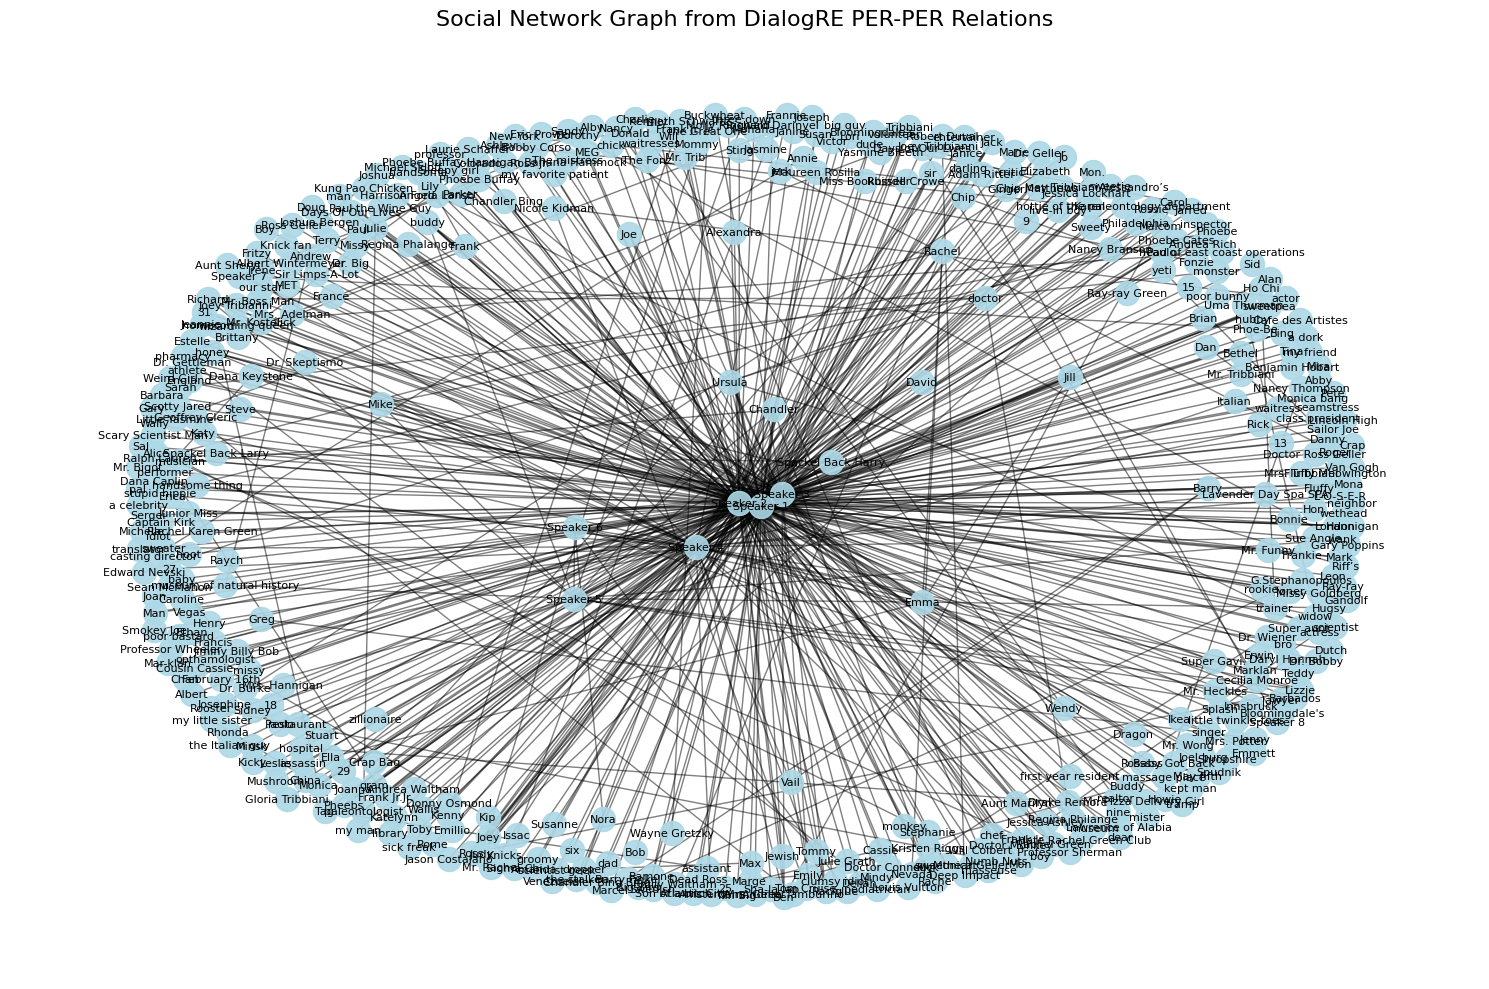

In [ ]:
def visualize_social_graph(G, figsize=(15, 10)):
    """Visualize the social network graph"""
    plt.figure(figsize=figsize)

    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    plt.title("Social Network Graph from DialogRE PER-PER Relations", size=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the graph
if social_graph.number_of_nodes() > 0:
    visualize_social_graph(social_graph)
else:
    print("No nodes to visualize")

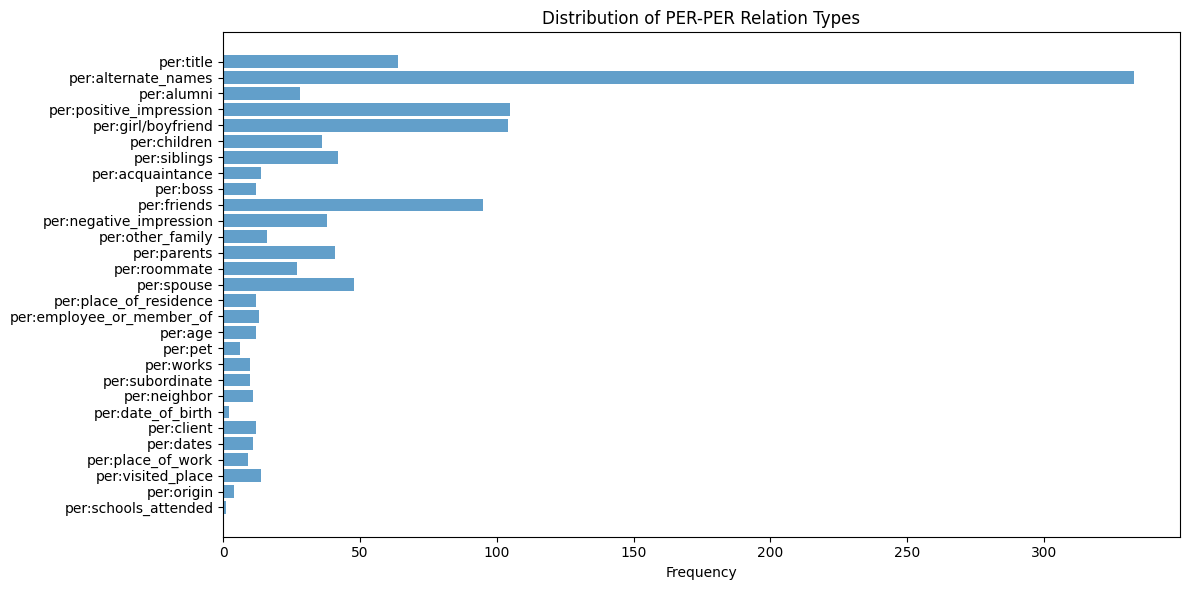

In [ ]:
def plot_relation_distribution(relation_counts, figsize=(12, 6)):
    """Plot the distribution of relation types"""
    plt.figure(figsize=figsize)

    # Prepare data
    relations = list(relation_counts.keys())
    counts = list(relation_counts.values())

    # Create bar plot
    y_pos = np.arange(len(relations))
    plt.barh(y_pos, counts, alpha=0.7)
    plt.yticks(y_pos, relations)
    plt.xlabel('Frequency')
    plt.title('Distribution of PER-PER Relation Types')
    plt.gca().invert_yaxis()  # Invert y-axis to have highest at top
    plt.tight_layout()
    plt.show()

# Plot relation distribution
plot_relation_distribution(relation_counts)

In [ ]:
def export_social_data(G, relation_counts, graph_stats, output_dir="/content/drive/MyDrive/My Research/dialogre/social_graph_output"):
    """Export social graph data for external analysis"""
    os.makedirs(output_dir, exist_ok=True)

    # Prepare graph for GEXF export by converting list attribute to string
    G_export = G.copy()
    for u, v, data in G_export.edges(data=True):
        if 'relations' in data and isinstance(data['relations'], list):
            # Convert list of relations to a single comma-separated string
            G_export[u][v]['relations'] = ", ".join(data['relations'])

    # Export graph as GEXF (for Gephi, Cytoscape, etc.)
    try:
        nx.write_gexf(G_export, os.path.join(output_dir, "social_graph.gexf"))
    except Exception as e:
        print(f"Error writing GEXF file: {e}")

    # Export node and edge lists
    nodes_df = pd.DataFrame([(node, data) for node, data in G.nodes(data=True)],
                           columns=['node', 'attributes'])
    # Convert edge attributes to string for CSV export as well
    edges_data_for_df = []
    for u, v, data in G.edges(data=True):
        edge_data_copy = data.copy()
        if 'relations' in edge_data_copy and isinstance(edge_data_copy['relations'], list):
             edge_data_copy['relations'] = ", ".join(edge_data_copy['relations'])
        edges_data_for_df.append((u, v, edge_data_copy))

    edges_df = pd.DataFrame(edges_data_for_df, columns=['source', 'target', 'attributes'])

    nodes_df.to_csv(os.path.join(output_dir, "nodes.csv"), index=False)
    edges_df.to_csv(os.path.join(output_dir, "edges.csv"), index=False)

    # Export statistics
    # Check if graph_stats is not None or empty
    if graph_stats:
        stats_df = pd.DataFrame([graph_stats])
        stats_df.to_csv(os.path.join(output_dir, "graph_statistics.csv"), index=False)
    else:
        print("graph_stats is not available, skipping statistics export.")


    # Export relation counts
    rel_counts_df = pd.DataFrame(list(relation_counts.items()),
                                columns=['relation_type', 'count'])
    rel_counts_df.to_csv(os.path.join(output_dir, "relation_counts.csv"), index=False)

    # Export JSON summary
    summary = {
        'graph_statistics': graph_stats if graph_stats else {}, # Include stats if available
        'relation_counts': relation_counts,
        # Add a check before accessing degree_centrality
        'top_nodes_by_degree': dict(sorted(nx.degree_centrality(G).items(),
                                         key=lambda x: x[1], reverse=True)[:10]) if G.number_of_nodes() > 0 else {}
    }

    with open(os.path.join(output_dir, "summary.json"), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"Social graph data exported to {output_dir}")

# Export the data
# Ensure graph_stats is passed correctly from analysis function
export_social_data(social_graph, relation_counts, graph_stats)

Social graph data exported to /content/drive/MyDrive/My Research/dialogre/social_graph_output


In [ ]:
def build_conversation_specific_graphs(per_per_relations):
    """Build separate social graphs for each conversation"""
    conversation_graphs = {}

    # Group relations by conversation
    conv_relations = defaultdict(list)
    for rel in per_per_relations:
        conv_relations[rel['conversation_id']].append(rel)

    # Build graph for each conversation
    for conv_id, relations in conv_relations.items():
        G, _ = build_social_graph(relations)
        conversation_graphs[conv_id] = G

    print(f"Built {len(conversation_graphs)} conversation-specific social graphs")

    # Analyze each conversation graph
    for conv_id, G in list(conversation_graphs.items())[:5]:  # Show first 5
        print(f"\nConversation {conv_id}:")
        print(f"  Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
        if G.number_of_nodes() > 0:
            print(f"  Density: {nx.density(G):.4f}")

    return conversation_graphs

# Build conversation-specific graphs
conv_graphs = build_conversation_specific_graphs(per_per_relations)

Built 625 conversation-specific social graphs

Conversation conv_978:
  Nodes: 4, Edges: 2
  Density: 0.3333

Conversation conv_19:
  Nodes: 9, Edges: 5
  Density: 0.1389

Conversation conv_985:
  Nodes: 2, Edges: 1
  Density: 1.0000

Conversation conv_713:
  Nodes: 3, Edges: 2
  Density: 0.6667

Conversation conv_959:
  Nodes: 3, Edges: 2
  Density: 0.6667


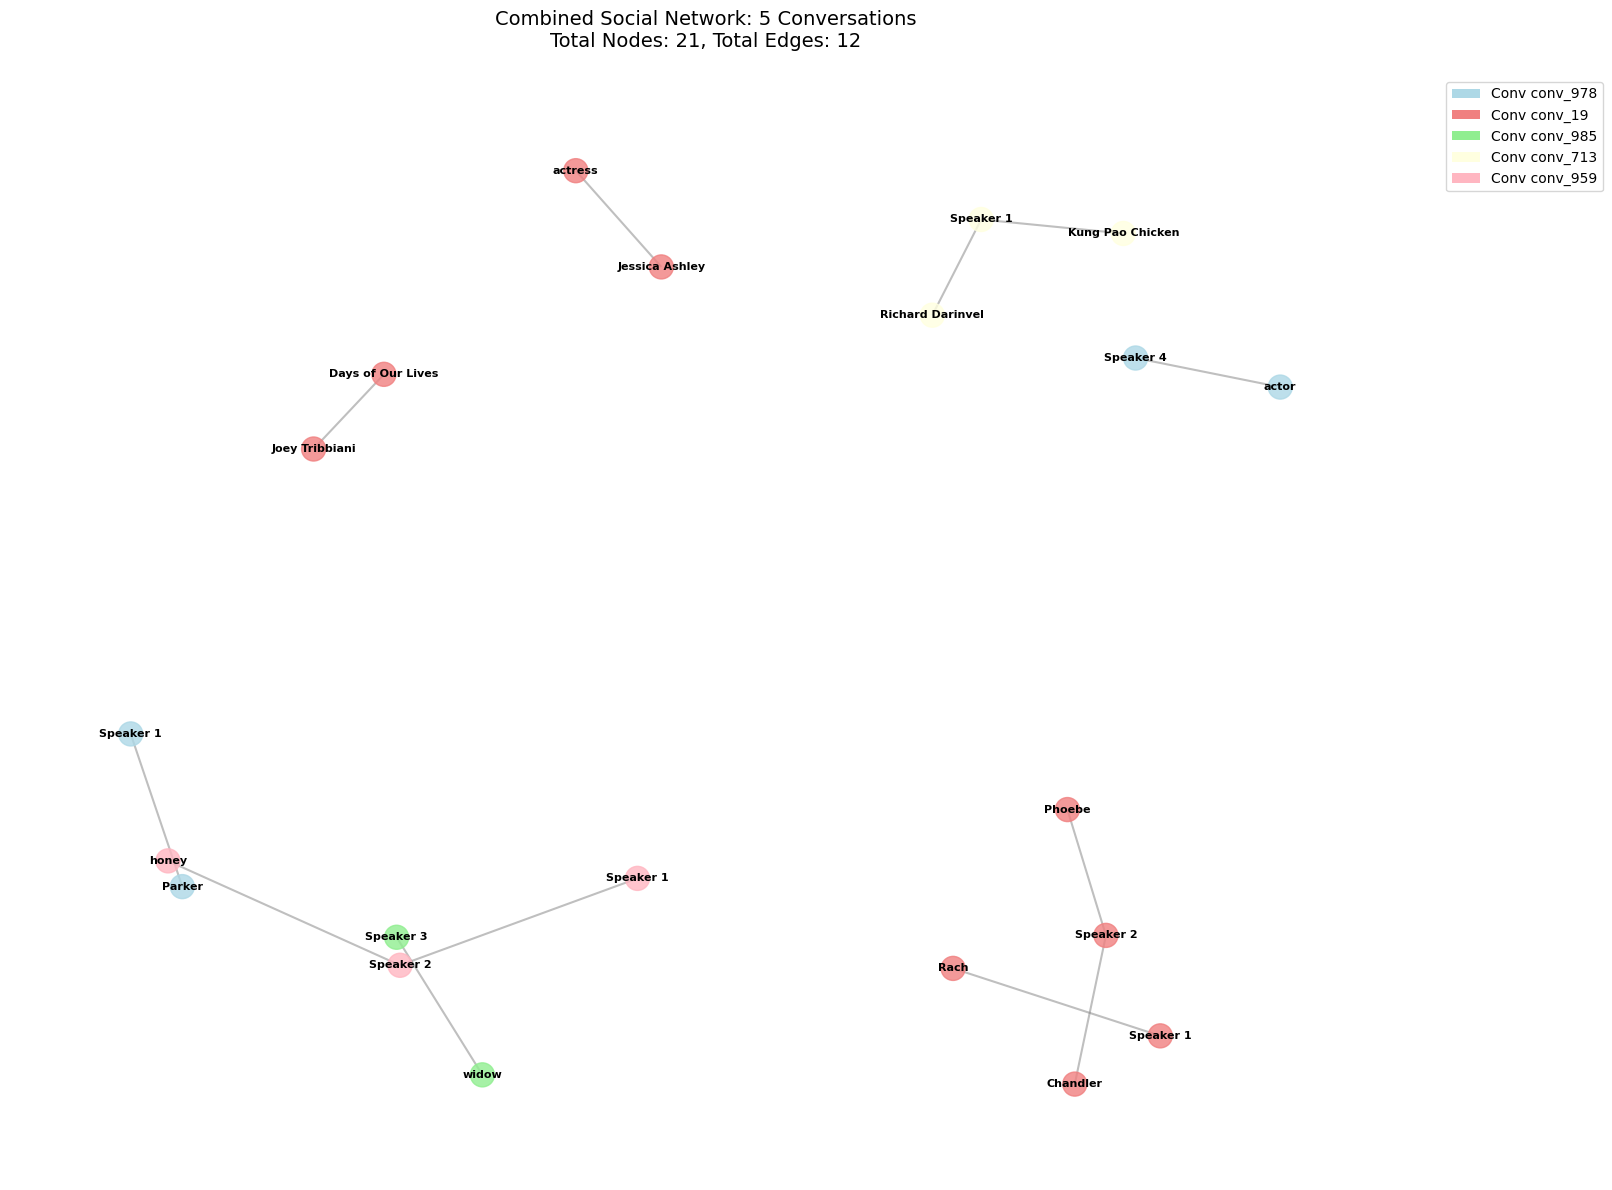

In [ ]:
def create_combined_conversation_graph(conversation_graphs, max_graphs=5):
    """Combine multiple conversation graphs into a single graph with different colors"""

    combined_G = nx.Graph()
    color_map = {}
    conversation_map = {}

    # Assign different colors to each conversation
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink',
             'lightcyan', 'lightsalmon', 'lightseagreen', 'plum', 'wheat']

    graphs_to_combine = list(conversation_graphs.items())[:max_graphs]

    for idx, (conv_id, G) in enumerate(graphs_to_combine):
        color = colors[idx % len(colors)]

        # Add nodes with conversation info
        for node in G.nodes():
            combined_G.add_node(f"{node}_{conv_id}",
                              original_name=node,
                              conversation=conv_id,
                              color=color)
            color_map[f"{node}_{conv_id}"] = color
            conversation_map[f"{node}_{conv_id}"] = conv_id

        # Add edges with conversation info
        for u, v, data in G.edges(data=True):
            combined_G.add_edge(f"{u}_{conv_id}", f"{v}_{conv_id}",
                              relations=data['relations'],
                              conversation=conv_id)

    return combined_G, color_map, conversation_map

def visualize_combined_graph(combined_G, color_map, conversation_map, figsize=(16, 12)):
    """Visualize the combined graph with conversation-based coloring"""

    plt.figure(figsize=figsize)

    # Create layout
    pos = nx.spring_layout(combined_G, k=1, iterations=100, seed=42)

    # Extract node colors and labels
    node_colors = [color_map[node] for node in combined_G.nodes()]
    node_labels = {node: combined_G.nodes[node]['original_name'] for node in combined_G.nodes()}

    # Draw the graph
    nx.draw_networkx_nodes(combined_G, pos, node_color=node_colors,
                          node_size=300, alpha=0.8)
    nx.draw_networkx_edges(combined_G, pos, width=1.5, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(combined_G, pos, labels=node_labels, font_size=8, font_weight='bold')

    # Create legend for conversations
    from matplotlib.patches import Patch

    # Get unique conversations and their colors
    conv_colors = {}
    for node, data in combined_G.nodes(data=True):
        conv = data['conversation']
        color = data['color']
        conv_colors[conv] = color

    legend_elements = [Patch(facecolor=color, label=f'Conv {conv}')
                      for conv, color in conv_colors.items()]

    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.title(f'Combined Social Network: {len(conv_colors)} Conversations\n'
             f'Total Nodes: {combined_G.number_of_nodes()}, '
             f'Total Edges: {combined_G.number_of_edges()}',
             fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return combined_G

# Create and visualize combined graph
combined_graph, color_map, conv_map = create_combined_conversation_graph(conv_graphs, max_graphs=5)
visualize_combined_graph(combined_graph, color_map, conv_map)